# Linear Support Vector Machine Trained with Gradient Descent

A support vector machine is a parametric model $\hat{y}(x_i)=W x_i - b$ such that $sign(\hat{y}(x_i)) \in \{-1,+1\}$ indicates the class membership.
the parameters of the matrix W and the offset b are trained such that a hinge loss is minimized:

The hinge loss is given by $l(y_i, \hat{y}(x_i))=\max(0, 1-y_i \hat{y}(x_i))=\max(0, 1-y_i (W x_i - b))$, where $y_i$ is the true label for the data point $x_i$.
Below the hinge loss is shown for a one-dimensional x and both cases $y_i \in \{-1, +1\}$. The optimizer will attempt to change model parameters $W$ and $b$ such that the loss is minimal. Samples with $y_i=1$ which are far enough to the right side of the decision point (where the loss for both cases $y_i \in \{-1, +1\}$ intersect) will not increase the loss - similarly samples with $y_i=-1$ which are far enough to the left will not increase the loss.

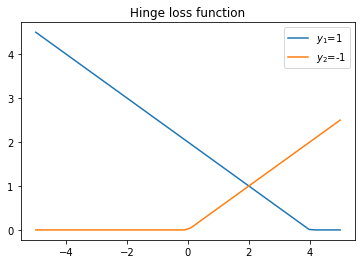

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5)
y_1 = 1
y_2 = -1
w = 0.5  # model parameter influencing the "width" of the decision boundary
b = 1  # model parameter
plt.plot(x, np.maximum(0, 1 - y_1 * (w * x - b)), label=f"$y_1$={y_1}")
plt.plot(x, np.maximum(0, 1 - y_2 * (w * x - b)), label=f"$y_2$={y_2}")
plt.title("Hinge loss function")
plt.legend()

## Make Dataset

In [2]:
from sklearn.datasets import make_classification

In [3]:
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
)
# encode y values as -1 or +1
y = (y - 0.5) * 2

## Define Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SVM(nn.Module):
    def __init__(self, dim_in):
        super(SVM, self).__init__()
        self.linear_transform = nn.Linear(dim_in, 1)

    def forward(self, x):
        x = self.linear_transform(x)
        return x

## Train Model

In [5]:
from torch import optim

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
model = SVM(2)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)


def loss_fn(output, target):
    # softplus is a smooth approximation to relu(x)=max(0,x)
    # relu occurs in the hinge loss l(y_score)=max(0,1-t*y_score)=relu(1-t*y_score)
    # where t in {+1,-1} is the intended output and y_score the output of the classifier
    return torch.mean(F.softplus(torch.ones_like(target) - target * output.flatten()))

In [6]:
losses = []
n_epochs = 7000  # potentially overfitting to the training data
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, y)
    loss.backward()
    losses.append(loss.detach().numpy())
    optimizer.step()

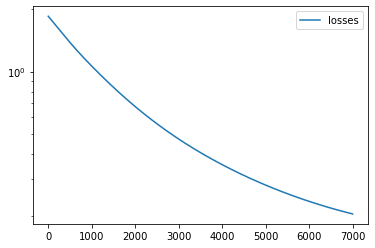

In [7]:
plt.plot(losses, label="losses")
plt.yscale("log")
plt.legend()

## Analyze Model Performance

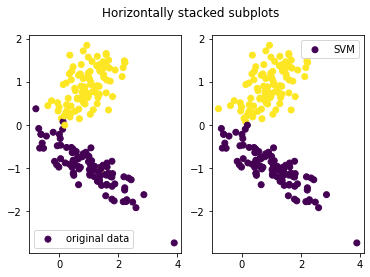

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Horizontally stacked subplots")
ax1.scatter(X[:, 0], X[:, 1], c=y, label="original data")
ax1.legend()

y_pred = torch.sign(model(X))[:, 0]
ax2.scatter(X[:, 0], X[:, 1], c=y_pred.detach().numpy(), label="SVM")
ax2.legend()

## Investigating the Support Points
The support points are the points significantly contributing to the position of the decision boundary.
Looking at the pointwise loss, we see that points far from the decision boundary have negligible loss.

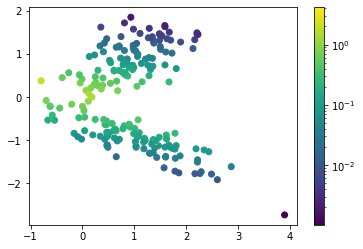

In [9]:
import matplotlib

loss_per_point = F.softplus(torch.ones_like(y) - y * output.flatten()).detach().numpy()
plt.scatter(X[:, 0], X[:, 1], c=loss_per_point, norm=matplotlib.colors.LogNorm())
plt.colorbar()